In [1]:
import nltk
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from collections import Counter

In [2]:
# Ensure necessary resources are downloaded
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\romaf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\romaf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
df = pd.read_csv("dblp-v10-titles_and_date-only.csv")

In [4]:
df = df.head(10000)

In [5]:
def token_and_filter_pos_combos(text_corpus):
      
    corpus = []
    for sent in tqdm(text_corpus):

        sent_tokens = []
        
        words = []
        for word,tag in nltk.pos_tag(nltk.word_tokenize(sent.lower())):
            if tag in {"JJ","JJR","JJS","NN","NNS","NNP","NNPS"}:
                words.append(word)
            else:
                if len(words) > 0:
                    sent_tokens.append(" ".join(words))
                words = []
        if len(words) > 0:
                    sent_tokens.append(" ".join(words))
        corpus.append(sent_tokens)
    return(corpus)

In [34]:
terms = token_and_filter_pos_combos(df['title'].to_list())

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1701.45it/s]


In [7]:
import math
from collections import Counter

def compute_tf_icf(sentence_terms):
    # Flatten list of terms for TF computation
    flattened_terms = [term for sentence in sentence_terms for term in sentence]
    term_counts = Counter(flattened_terms)
    
    # Total number of terms
    total_terms = len(flattened_terms)
    
    # Compute TF for each term
    tf = {term: count / total_terms for term, count in term_counts.items()}
    
    # Compute ICF for each term
    total_sentences = len(sentence_terms)
    term_in_sentences = Counter(term for sentence in sentence_terms for term in set(sentence))
    icf = {term: math.log(total_sentences / (1 + count)) for term, count in term_in_sentences.items()}
    
    # Compute TF-ICF
    tf_icf = {term: tf[term] * icf[term] for term in tf.keys()}
    
    return tf_icf

In [8]:
tf_icf_scores = compute_tf_icf(terms)

In [9]:
# Step 3: Train Word2Vec embedding
model = Word2Vec(sentences=terms, vector_size=50)

In [10]:
# Extract embeddings
words = [x for x in list(model.wv.key_to_index.keys()) if tf_icf_scores[x] >= 0.001]
embeddings = [model.wv[word] for word in words]

# Step 4: Perform UMAP dimensionality reduction
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [11]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_scaled)

c:\Users\romaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
from sklearn.cluster import KMeans
import numpy as np

# Example points in 2D space (replace with your points)
points = np.array(embeddings_scaled.tolist())

# Number of clusters (choose based on your data or use a method like the elbow method to find the optimal number)
kmeans = KMeans(n_clusters=8)
kmeans.fit(points)

kclasses = kmeans.predict(embeddings_scaled.tolist())


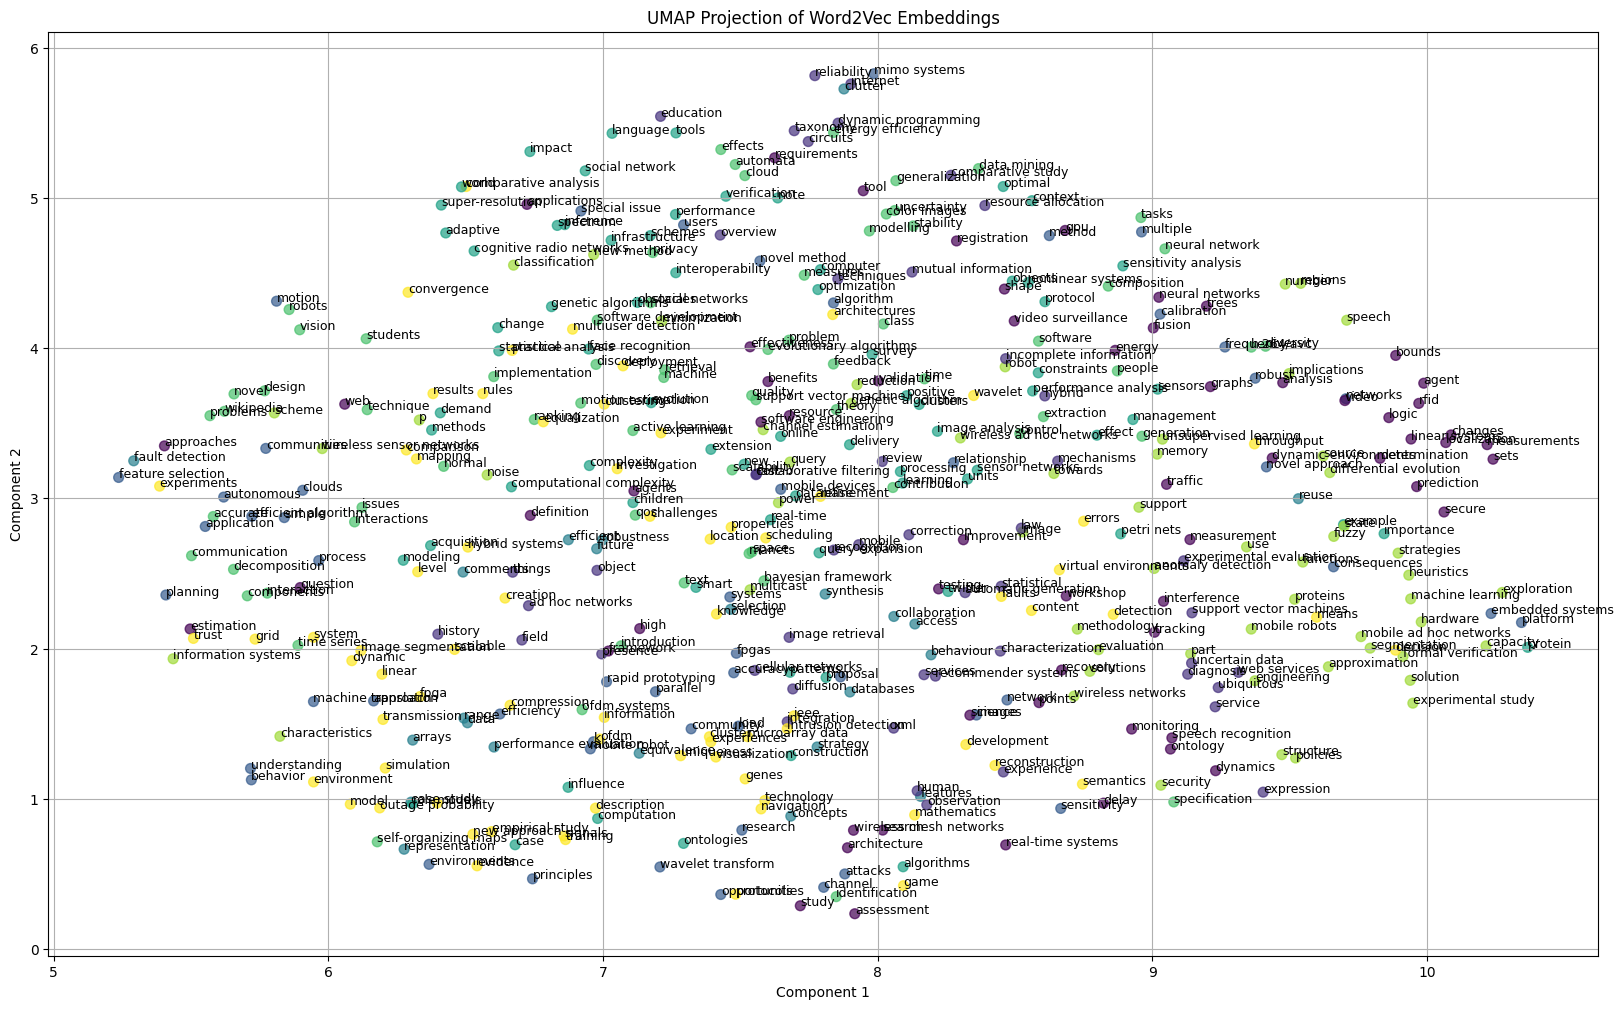

In [13]:
# Step 5: Visualize results
plt.figure(figsize=(20, 12))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c =kclasses , s=50, alpha=0.7)

for i, word in enumerate(words):
    plt.text(umap_embeddings[i, 0], umap_embeddings[i, 1], word, fontsize=9)

plt.title("UMAP Projection of Word2Vec Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [14]:
import numpy as np
from collections import Counter

class KNNWithProximity:
    def __init__(self, k=3, max_distance=None):
        """
        Initialize the k-NN classifier with proximity filtering.

        Parameters:
            k (int): Number of neighbors to consider.
            max_distance (float): Maximum distance threshold for making predictions.
        """
        self.k = k
        self.max_distance = max_distance
        self.points = None
        self.labels = None

    def fit(self, points, labels):
        """
        Fit the model with training data.

        Parameters:
            points (array-like): Training points, shape (n_samples, n_features).
            labels (array-like): Class labels for training points, shape (n_samples,).
        """
        self.points = np.array(points)
        self.labels = np.array(labels)

    def predict(self, new_points):
        """
        Predict the class for new points.

        Parameters:
            new_points (array-like): Points to predict, shape (m_samples, n_features).

        Returns:
            list: Predicted classes or None for points outside the proximity threshold.
        """
        new_points = np.array(new_points)
        predictions = []

        for point in new_points:
            distances = np.linalg.norm(self.points - point, axis=1)
            
            # Get indices of k nearest neighbors
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_distances = distances[nearest_indices]

            # Check if the nearest neighbor is within max_distance
            if self.max_distance is not None and np.all(nearest_distances > self.max_distance):
                predictions.append(None)
            else:
                nearest_labels = self.labels[nearest_indices]
                most_common_label = Counter(nearest_labels).most_common(1)[0][0]
                predictions.append(most_common_label)

        return predictions

In [15]:
h3_hex_knn = KNNWithProximity(k=2, max_distance=0.2)
h3_hex_knn.fit(umap_embeddings,kclasses)

In [16]:
words_emb = []
for w,e,k in zip(words,umap_embeddings,kclasses):
    e = e.tolist()
    e.reverse()
    words_emb.append({"words":w,"coord": e,'class':k})

words_emb

[{'words': 'design',
  'coord': [3.71549129486084, 5.767985820770264],
  'class': 5},
 {'words': 'application',
  'coord': [2.8126890659332275, 5.551921844482422],
  'class': 2},
 {'words': 'analysis',
  'coord': [3.769575357437134, 9.474722862243652],
  'class': 0},
 {'words': 'systems',
  'coord': [2.343384265899658, 7.461823463439941],
  'class': 2},
 {'words': 'performance',
  'coord': [4.889217853546143, 7.26387357711792],
  'class': 4},
 {'words': 'evaluation',
  'coord': [1.992754340171814, 8.80412483215332],
  'class': 6},
 {'words': 'wireless sensor networks',
  'coord': [3.330897808074951, 5.97773551940918],
  'class': 6},
 {'words': 'implementation',
  'coord': [3.809931516647339, 6.602222442626953],
  'class': 5},
 {'words': 'algorithm',
  'coord': [4.300840377807617, 7.839077472686768],
  'class': 2},
 {'words': 'towards',
  'coord': [3.1653189659118652, 8.641559600830078],
  'class': 6},
 {'words': 'applications',
  'coord': [4.956254959106445, 6.72319221496582],
  'class

In [17]:
colors = [(230, 25, 75),
 (60, 180, 75),
 (255, 225, 25),
 (67, 99, 216),
 (245, 130, 49),
 (145, 30, 180),
 (66, 212, 244),
 (240, 50, 230),
 (191, 239, 69),
 (250, 190, 212),
 (70, 153, 144),
 (220, 190, 255),
 (154, 99, 36),
 (255, 250, 200),
 (128, 0, 0),
 (170, 255, 195),
 (128, 128, 0),
 (255, 216, 177),
 (0, 0, 117),
 (169, 169, 169),
 (0, 0, 0),]

In [18]:
def gen_hexes(x1,x2,y1,y2,resolution,number_of_samp = 100,):
    hexes = []
    for x in np.linspace(x1,x2,number_of_samp):
        for y in np.linspace(y1,y2,number_of_samp):
            hexes.append(h3.latlng_to_cell(x,y,resolution))
    return list(set(hexes))

In [19]:
def gen_surround(points,resolution):
    all_hexes = set()
    for x,y in points:
        all_hexes.update(gen_hexes(x-1,x+1,y-1,y+1,resolution))

    return list(all_hexes)

In [20]:
import numpy as np
import h3
RESOLUTON = 6

In [21]:
dummy_hexes = gen_surround(umap_embeddings,RESOLUTON)

In [22]:
h3_hex_classes = h3_hex_knn.predict([ h3.cell_to_latlng(x) for x in dummy_hexes])

In [23]:
parsed_dict = {}
for c in colors:
    parsed_dict[c] = []
parsed_dict[(255,255,255)] = [] # for Empty hexes

for h3_h,hex_class in zip(dummy_hexes,h3_hex_classes):
    if hex_class is None:
        parsed_dict[(255,255,255)].append(h3_h)
    else:
        parsed_dict[colors[hex_class]].append(h3_h)

In [24]:
data = []
for i,v in parsed_dict.items():
    if len(v) > 0:
        data.append({"color":i,'hexIds':v})

In [25]:
import json

words_emb_json = [ {
    'words': x['words'],               
    'coord': [ float(y) for y in x['coord']],
    'class': int(x['class']),
    'tf_icf': tf_icf_scores[x['words']],
    }for x in words_emb]

with open('words_emb.json','w') as f:
    json.dump(words_emb_json,f)

In [26]:
with open('hex_data.json','w') as f:
    json.dump(data,f)

In [36]:
yearly_terms

{2008: ['new approach',
  'image segmentation',
  'load',
  'application',
  'integration',
  'algorithm',
  'wireless ad hoc networks',
  'students',
  'people',
  'mobile robot',
  'evolution',
  'research',
  'control',
  'ofdm systems',
  'evaluation',
  'application',
  'research',
  'tracking',
  'impact',
  'performance',
  'objects',
  'application',
  'analysis',
  'exploration',
  'effects',
  'number',
  'sensor networks',
  'design',
  'learning',
  'relationship',
  'efficient',
  'implications',
  'power',
  'study',
  'ontology',
  'integration',
  'simulation',
  'active learning',
  'application',
  'ontology',
  'extension',
  'h.264/avc',
  'ontology',
  'image retrieval',
  'calibration',
  'machine learning',
  'scheme',
  'incomplete information',
  'reconstruction',
  'throughput',
  'wireless sensor networks',
  'images',
  'objects',
  'investigation',
  'objects',
  'towards',
  'mobile robots',
  'evaluation',
  'social networks',
  'performance',
  'research

In [48]:
yearly_terms = {year: [] for year in df['year'].unique()}

for terms_words, y in zip(terms,df['year']):
    for word in terms_words:
        if tf_icf_scores[word] > 0.001:
            yearly_terms[y].append(word)

year_terms_scores = {year: [] for year in df['year'].unique()}

for year, terms_words in yearly_terms.items():
    if len(terms_words) == 0:
        del year_terms_scores[year]
        continue
    scores = MinMaxScaler((0.1,1)).fit_transform(np.array(list(Counter(yearly_terms[year]).values())).reshape(-1,1))
    year_terms_scores[year] = {t:float(s[0]) for t,s in zip(terms_words,scores)}     

In [65]:
heat_words_data = []

for x,l in zip(words,umap_embeddings.tolist()):

    word_data = [("coord",(float(l[0]),float(l[1])))]

    for y,word_dict in year_terms_scores.items():
        if x in word_dict:
            word_data.append((int(y),word_dict[x]))
        else:
            word_data.append((int(y),0))
    
    heat_words_data.append({p:v for p,v in word_data})


In [67]:
with open('heat_map_data.json','w') as f:
    json.dump(heat_words_data,f)

In [30]:
words_emb1 = [{'words': x['words'], 'coord' : x['coord']} for x in words_emb]

In [31]:
import pydeck as pdk

from pydeck.types import String

layer = pdk.Layer(
    "H3ClusterLayer",
    data,
    # pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagons="hexIds",
    get_fill_color="color",
    get_line_color=[255, 255, 255],
    line_width_min_pixels=1,
    opacity=0.1,
)
layer2 = pdk.Layer(
    "TextLayer",
    words_emb1,
    pickable=True,
    get_position="coord",
    get_text="words",
    get_size=13,
    opacity=0.8,
    get_color=[255,255,255],
    get_angle=0,
    # Note that string constants in pydeck are explicitly passed as strings
    # This distinguishes them from columns in a data set
    get_text_anchor=String("middle"),
    get_alignment_baseline=String("center"),
)


# Set the viewport location
view_state = pdk.ViewState(
    longitude=23,
    latitude=14,
    zoom=5,
    min_zoom=1,
    max_zoom=15,
    pitch=0,
    bearing=0)



In [ ]:
# Combined all of it and render a viewport
from ipywidgets import HTML

text = HTML(value='Move the viewport')

def callback(widget_instance, payload):
    text.value = 1


r = pdk.Deck(layers=[layer,layer2], initial_view_state=view_state,map_provider="None")
r.deck_widget.on_click(callback)
display(text)
r.show()
r.to_html('hexagon-example.html')